In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import PIL
import pathlib 
import glob
import cv2
from tqdm import tqdm
import tensorflow as tf 
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,MaxPooling2D,Activation,Rescaling,Flatten
from keras.activations import relu,softmax
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split

#### Loading the dataset

Number of images : 20000


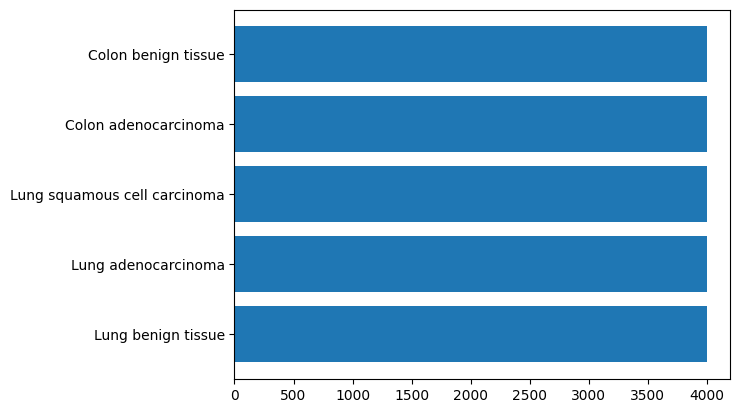

In [7]:
dataset_dir = pathlib.Path("images/")
images = list(dataset_dir.glob("*/*.jpeg"))
print(f"Number of images : {len(images)}")

lbt = dataset_dir.glob('lung_n/*')
laca = dataset_dir.glob('lung_aca/*')
lscc = dataset_dir.glob('lung_scc/*')
cacc = dataset_dir.glob('colon_aca/*')
cbt = dataset_dir.glob('colon_n/*')

lung_benign_tissue = list(lbt)
lung_adenocarcinoma = list(laca)
lung_squamous_cell_carcinoma = list(lscc)
colon_adenocarcinoma = list(cacc)
colon_benign_tissue = list(cbt)

x = ['Lung benign tissue','Lung adenocarcinoma','Lung squamous cell carcinoma','Colon adenocarcinoma','Colon benign tissue']
y = [len(lung_benign_tissue),len(lung_adenocarcinoma),len(lung_squamous_cell_carcinoma),len(colon_adenocarcinoma),len(colon_benign_tissue)]

plt.barh(x,y)
plt.show()

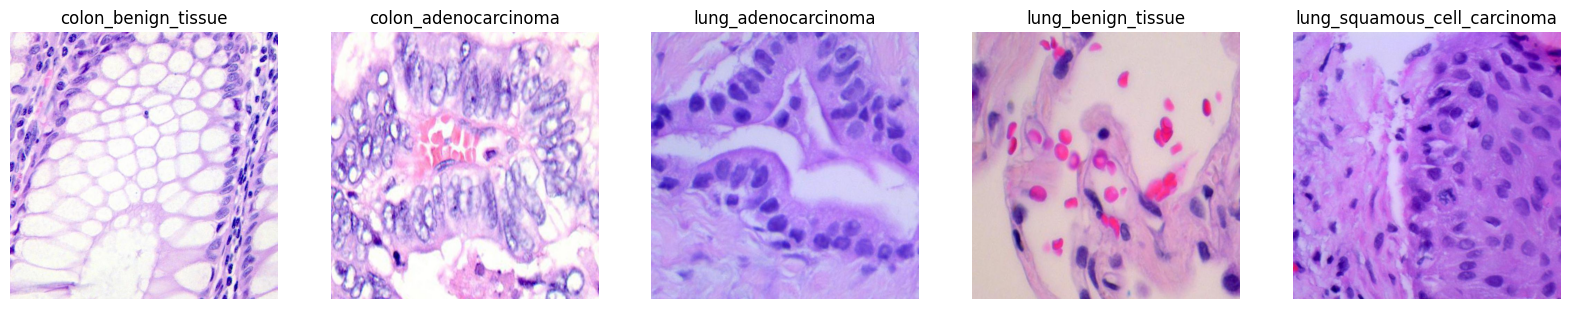

In [8]:
plt.figure(figsize=(20,20))

plt.subplot(1,5,1)
img1 = cv2.imread('../lung_colon_image_set/colon_image_sets/colon_n/colonn1.jpeg')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)) 
plt.axis('off')  
plt.title("colon_benign_tissue")

plt.subplot(1,5,2)
img2 = cv2.imread('../lung_colon_image_set/colon_image_sets/colon_aca/colonca10.jpeg')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))  
plt.axis('off')  
plt.title('colon_adenocarcinoma')

plt.subplot(1,5,3)
img3 = cv2.imread('../lung_colon_image_set/lung_image_sets/lung_aca/lungaca100.jpeg')
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))  
plt.axis('off') 
plt.title('lung_adenocarcinoma')

plt.subplot(1,5,4)
img4 = cv2.imread('../lung_colon_image_set/lung_image_sets/lung_n/lungn1561.jpeg')
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))  
plt.axis('off') 
plt.title('lung_benign_tissue')

plt.subplot(1,5,5)
img3 = cv2.imread('../lung_colon_image_set/lung_image_sets/lung_scc/lungscc1566.jpeg')
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))  
plt.axis('off') 
plt.title('lung_squamous_cell_carcinoma')

plt.show()

In [9]:
batch_size = 128
img_height = 227 
img_width = 227 

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=100,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 20000 files belonging to 5 classes.
Using 16000 files for training.


In [11]:
validatation_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.3,
    subset="validation",
    seed=100,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 20000 files belonging to 5 classes.
Using 6000 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [13]:
num_of_batches = len(validatation_ds)

test_ds = validatation_ds.take(num_of_batches // 2)
val_ds = validatation_ds.skip(num_of_batches // 2)

In [38]:
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=autotune)
validatation_ds = validatation_ds.cache().prefetch(buffer_size=autotune)

#### Creating the Alexnet model

In [39]:
model = Sequential()

model.add(Rescaling(1./255,input_shape=(img_height,img_width,3)))
model.add(Conv2D(filters=96,strides=4,padding="valid",activation='relu',kernel_size=(11,11)))
model.add(Activation('relu'))
model.add(MaxPooling2D(3,strides=2))

model.add(Conv2D(kernel_size=(5,5),filters=256,strides=1,padding="same",activation='relu'))
model.add(MaxPooling2D(3,strides=2))

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=1,padding="same",activation='relu'))
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=1,padding="same",activation='relu'))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',strides=1,padding="same"))
model.add(MaxPooling2D(3,strides=2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(4096,activation='relu'))
model.add(Dense(4096,activation='relu'))
model.add(Dense(5,activation='softmax'))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 activation_2 (Activation)   (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                 

In [40]:
model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

In [41]:
history = model.fit(train_ds,validation_data=validatation_ds,epochs=10)

Epoch 1/10


125/125 [==============================] - 705s 5s/step - loss: 1.7392 - accuracy: 0.2745 - val_loss: 1.0126 - val_accuracy: 0.4762
Epoch 2/10
125/125 [==============================] - 652s 5s/step - loss: 0.9011 - accuracy: 0.5761 - val_loss: 0.7358 - val_accuracy: 0.6795
Epoch 3/10
125/125 [==============================] - 653s 5s/step - loss: 0.7658 - accuracy: 0.6686 - val_loss: 0.6486 - val_accuracy: 0.7472
Epoch 4/10
125/125 [==============================] - 652s 5s/step - loss: 0.6054 - accuracy: 0.7519 - val_loss: 0.4823 - val_accuracy: 0.8210
Epoch 5/10
125/125 [==============================] - 652s 5s/step - loss: 0.4202 - accuracy: 0.8376 - val_loss: 0.3687 - val_accuracy: 0.8527
Epoch 6/10
125/125 [==============================] - 650s 5s/step - loss: 0.3567 - accuracy: 0.8641 - val_loss: 0.2712 - val_accuracy: 0.8958
Epoch 7/10
125/125 [==============================] - 649s 5s/step - loss: 0.2762 - accuracy: 0.8941 - val_loss: 0.2194 - val_accuracy: 0.9152
Epoch 8/10

In [42]:
hist_data = history.history
hist_df = pd.DataFrame(hist_data)
hist_df.to_csv('alexnet-tensorflow.csv',index=False)

#### Plotting accuracy and loss

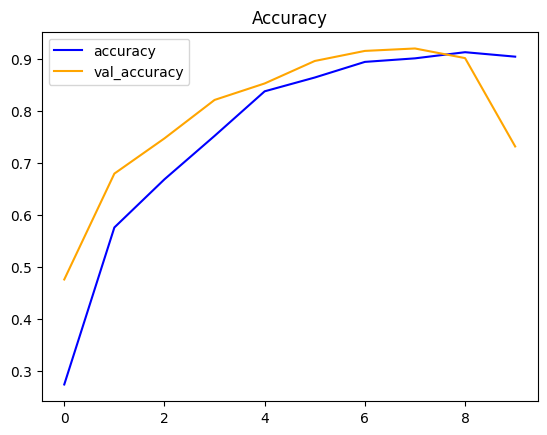

In [43]:
plt.plot(hist_df['accuracy'],color='blue',label='accuracy')
plt.plot(hist_df['val_accuracy'],color='orange',label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()
# plt.savefig('accuracy.png')

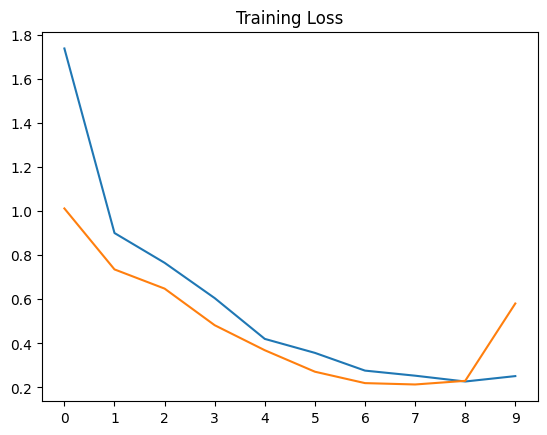

In [44]:
x=list(range(0,10))
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.xticks(x)
plt.title("Training Loss")
plt.show()
# plt.savefig("loss.png")

#### Saving the model

In [45]:
model = keras.models.load_model('alexnet-tensorflow.h5')

#### Model Evaluation

In [46]:
model.evaluate(test_ds)

23/23 [==============================] - 22s 899ms/step - loss: 0.1579 - accuracy: 0.9406


[0.15790337324142456, 0.940557062625885]

In [4]:
model = keras.models.load_model('alexnet-tensorflow.h5')